In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

Download data:
* https://www.kaggle.com/c/carvana-image-masking-challenge/data
 - use kaggle API and download command to download all data easily with a single command line command
 - unzip all files into target directory

In [3]:
PATH = Path('D:/data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [4]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [5]:
TRAIN_DN = 'train' #'train-128'
MASKS_DN = 'train_masks-png' #'train_masks-128'
sz = 128
bs = 64
nw = 16

In [6]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get_n(self): return len(self.y)

In [7]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [8]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [9]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]

In [10]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

## Simple upsample

In [11]:
f = resnet34
cut,lr_cut = model_meta[f]

In [12]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [13]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [14]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [15]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [16]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [17]:
m_base = get_base()

In [18]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [19]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [20]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [21]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|██████████████████████████████████████████████████████████████▏        | 56/64 [05:18<00:45,  5.68s/it, loss=3.99]

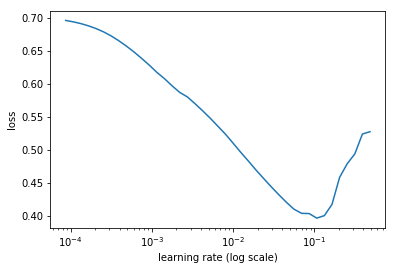

In [22]:
learn.lr_find()
learn.sched.plot()

In [23]:
lr=4e-2

In [24]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]


Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice                                                                       
    0      0.121917   0.057533   0.975782   0.940928  
    1      0.064619   0.039291   0.983474   0.959538                                                                   
    2      0.04669    0.036395   0.984645   0.962178                                                                   
    3      0.039443   0.029336   0.988219   0.971485                                                                   



[0.029335681, 0.9882188625633717, 0.9714853663061372]

In [25]:
learn.save('tmp')

In [26]:
learn.load('tmp')

In [27]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])/2

In [28]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice                                                                       
    0      0.034901   0.028185   0.988622   0.972547  
    1      0.031153   0.026148   0.989544   0.974767                                                                   
    2      0.030172   0.02544    0.989906   0.97559                                                                    
    3      0.027543   0.023963   0.990568   0.977226                                                                   



[0.023962796, 0.9905682392418385, 0.9772255754108857]

In [29]:
learn.save('128')

## U-net (ish)

In [31]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [32]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [33]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [34]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [35]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [36]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|███████████████████████████████████████████████████████████████▏       | 57/64 [05:13<00:38,  5.49s/it, loss=1.78]

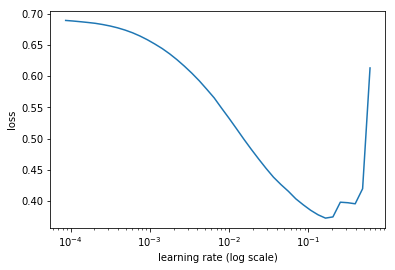

In [37]:
learn.lr_find()
learn.sched.plot()

In [38]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]


Exception in thread Thread-22:
Traceback (most recent call last):
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice                                                                       
    0      0.08075    0.036576   0.985802   0.966294  
    1      0.040218   0.025602   0.989557   0.974453                                                                   
    2      0.029387   0.021433   0.991344   0.979009                                                                   
    3      0.027583   0.0205     0.991988   0.98067                                                                    
    4      0.024562   0.0203     0.991974   0.980724                                                                   
    5      0.025499   0.019058   0.992692   0.982357                                                                   
    6      0.022859   0.018237   0.992806   0.98259                                                                    
    7      0.022806   0.01779    0.993098   0.983329                                                     

[0.017789679, 0.9930975027382374, 0.9833288339338584]

In [39]:
learn.save('128urn-tmp')

In [40]:
[o.features.size() for o in m.sfs]

[torch.Size([48, 64, 64, 64]),
 torch.Size([48, 64, 32, 32]),
 torch.Size([48, 128, 16, 16]),
 torch.Size([48, 256, 8, 8])]

In [41]:
learn.load('128urn-tmp')

In [42]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [43]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice                                                                       
    0      0.022513   0.017917   0.992982   0.983075  
    1      0.023449   0.018826   0.992477   0.981828                                                                   
    2      0.023552   0.018152   0.992835   0.982773                                                                   
    3      0.02387    0.017937   0.992889   0.982821                                                                   
    4      0.022269   0.017885   0.993067   0.983196                                                                   
    5      0.02179    0.016991   0.9933     0.983863                                                                   
    6      0.336561   0.150941   0.934284   0.832026                                                                   
    7      0.15212    0.053609   0.979163   0.949898                                                     

[0.021125605, 0.9917263574898243, 0.9800503375491196]

In [44]:
learn.save('128urn-0')

In [45]:
learn.load('128urn-0')

In [46]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

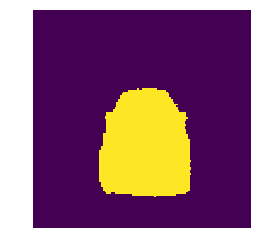

In [47]:
# ax = show_img(denorm(x)[0])
show_img(py[0][0]>0);

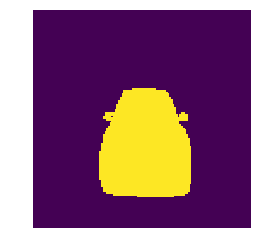

In [48]:
# ax = show_img(denorm(x)[0])
show_img(y[0,...,-1]);

## 512x512

In [58]:
sz=512
bs=8

In [59]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [51]:
m_base = get_bas
e()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [52]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [53]:
learn.load('128urn-0')

In [54]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice                                                                       
    0      0.026473   0.01946    0.992729   0.982816  
    1      0.021197   0.015986   0.994104   0.985822                                                                   
    2      0.015101   0.016395   0.993705   0.985235                                                                   
    3      0.016749   0.013303   0.995046   0.98806                                                                    
    4      0.013908   0.012695   0.995307   0.988683                                                                   



[0.012695112, 0.9953066772884793, 0.9886833944402995]

In [55]:
learn.save('512urn-tmp')

In [56]:
learn.unfreeze()
learn.bn_freeze(True)

In [57]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  0%|                                                                                          | 0/255 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
learn.save('512urn')

In [ ]:
learn.load('512urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [ ]:
learn.load('512urn')

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('1024urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/2,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);